<a href="https://colab.research.google.com/github/tamburins/ESAA_2023/blob/main/ESAA_4_14pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://dacon.io/competitions/official/235670/codeshare/1840?page=undefined&dtype=recent&ptype=undefined

# 1. Facebook fasttext 이용 text classification

In [1]:
pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4395549 sha256=c6bea2548499ae7c86176f47636d4a78f62cee19c189a877b1abd26a64952dd1
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext


In [ ]:
import fasttext

## word reepresentation
# # Skipgram model :
# skip_model = fasttext.train_unsupervised('./author.txt', model='skipgram')
# skip_model.save_model("skip_model.bin")
# print(skip_model.words)
# # or, cbow model :
# cbow_model = fasttext.train_unsupervised('./author.txt', model='cbow')
# cbow_model.save_model("cbow_model.bin")
# print(cbow_model.words)

#  디폴트로 돌리면 0.56

import pandas as pd
import numpy as np

train = pd.read_csv('/content/drive/MyDrive/ESAA/OB/novel/train.csv')
file=open('fasttexttrain.txt','w+')

for i in train.index:
  line = '__label__'+str(train['author'][i])+''+train['text'][i]
  file.write(line+'\n')

# Text Classification
# input             # training file path (required)
# model             # unsupervised fasttext model {cbow, skipgram} [skipgram]
# lr                # learning rate [0.05]
# dim               # size of word vectors [100]
# ws                # size of the context window [5]
# epoch             # number of epochs [5]
# minCount          # minimal number of word occurences [5]
# minn              # min length of char ngram [3]
# maxn              # max length of char ngram [6]
# neg               # number of negatives sampled [5]
# wordNgrams        # max length of word ngram [1]
# loss              # loss function {ns, hs, softmax, ova} [ns]
# bucket            # number of buckets [2000000]
# thread            # number of threads [number of cpus]
# lrUpdateRate      # change the rate of updates for the learning rate [100]
# t                 # sampling threshold [0.0001]
# verbose           # verbose [2]

text_clf_model = fasttext.train_supervised('fasttexttrain.txt', epoch=30, minCount=2, maxn=10, verbose=0)
print(text_clf_model.words)
print(text_clf_model.labels)

result = text_clf_model.predict('He was almost choking. There was so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; looked at odin, and was in evident perplexity.', k=5)
print(result)

test=pd.read_csv('/content/drive/MyDrive/ESAA/OB/novel/test_x.csv')
submission=pd.read_csv('/content/drive/MyDrive/ESAA/OB/novel/sample_submission.csv',index_col=False)


In [ ]:
for i in test.index:
  lable, proba = text_clf_model.predict(test['text'][i], k=5)
  for la, pr in zip(lable, proba):
    if '__lable__0'==la:
      submission.loc[i,'0']=pr
    elif '__lable__1'==la:
      submission.loc[i,'1']=pr
    elif '__lable__2'==la:
      submission.loc[i,'2']=pr
    elif '__lable__3'==la:
      submission.loc[i,'3']=pr
    elif '__lable__4'==la:
      submission.loc[i,'4']=pr

    # submission.loc[i, '0'] = proba[lable.loc('__label__0')]
    # submission.loc[i, '1'] = proba[4]
    # submission.loc[i, '2'] = proba[2]
    # submission.loc[i, '3'] = proba[0]
    # submission.loc[i, '4'] = proba[3]
submission.to_csv('result5_fasttext.csv', index=False)
print('end')

https://dacon.io/competitions/official/235670/codeshare/1823?page=2&dtype=recent

# 2. NLP 전처리

nlp 전처리는 데이터와 목적에 따라 다르나 주로 모델의 입력인 단어, 문장, 문서의 vector를 만들기 위해 진행이 되는 것으로 이번 신문기사 분류대회에서는 다음과 같이 진행

1. 데이터를 불러온 후 각 신문기사를 눈으로 확인하며 특수문자와 불용어 그리고 문장구조에 대한 감을 잡는다.

2. 문제의 목적과 분석자의 재량에 따라 불용어를 설정하고 리스트에 저장한다. 이번 대회에서는 특수문자와 조사만 제거해도 정확도가 어느정도 올라간다

3. 불용어 이외의 틑ㄱ수문자를 제거하는데 이번에는 패키지 re를 사용하여 한글, 영어소문자 제외 모든 글자를 제거함

4. 형태소 분석을 통해 문장을 형태소 단위의 토큰으로 분리하는데 이 떄 내가 설정한 불용어를 바탕으로 결과를 반환해주는 형태소 분석기를 사용해야 한다.

5. 형태소 단위의 토큰들을 기반으로 리스트에 저장된 불용어를 제거함

## 1. 형태소 분석
- 단어나 문장의 언어적 속성을 파악하는 것으로 품사의 태깅을 통해 이루어지며 한국어 형태소 분석을 위해 konlpy패키지에 있는 다양한 함수를 이용하여 진행할 수 있음

- 형태소 분석을 하는 이유는 주로 형태소 단위로 의미있는 단어를 가져가고 싶거나 품사 태깅을 통해 형용사나 명사를 추출하곳 ㅣㅍ을 떄 많이 이용

- 문장을 띄어쓰기 단위로 분류하여 vectorization을 하게되면 데이콘이라는 같은 의미의 토큰 세개가 서로 다른 vector를 갖게 되어 각기 다른 단어로 이해하게 되나, 형태소 분석을 통해 데이콘이라는 토큰을 추출하면 세 단어가 동일해진다.

- 모델링보다 성능에 더 중요할수도...?

### 1-1.Kkma

In [ ]:
pip install konlpy

In [ ]:
from konlpy.tag import Kkma
kkma = Kkma()

sentence = '데이콘에서 다양한 컴피티션을 즐기면서 실력있는 데이터 분석가로 성장하세요!!.'

print('형태소 단위로 문장 분리')
print('----------------------------')
print(kkma.morphs(sentence))
print('문장에서 명사 추출')
print('----------------------------')
print(kkma.nouns(sentence))

print(' ')
print('품사 태깅(pos)')
print('----------------------------')
print(kkma.pos(sentence))

### 1-2. Okt()

In [ ]:
from konlpy.tag import Okt
Okt = Okt()
sentence = '데이콘에서 다양한 컴피티션을 즐기면서 실력있는 데이터 분석가로 성장하세요!!.'

print('형태소 단위로 문장 분리')
print('----------------------------')
print(Okt.morphs(sentence))
print('문장에서 명사 추출')
print('----------------------------')
print(Okt.nouns(sentence))

print(' ')
print('품사 태깅(pos)')
print('----------------------------')
print(Okt.pos(sentence))

### 1-3. Mecab()



```
from konlpy.tag import Mecab
Mecab = Mecab()

sentence = '데이콘에서 다양한 컴피티션을 즐기면서 실력있는 데이터 분석가로 성장하세요!!.'

print('형태소 단위로 문장 분리')
print('----------------------------')
print(Mecab.morphs(sentence))
print('문장에서 명사 추출')
print('----------------------------')
print(Mecab.nouns(sentence))

print(' ')
print('품사 태깅(pos)')
print('----------------------------')
print(Mecab.pos(sentence))
```




이 외에도 형태소분석기가 트위터 코모란 한나움(?) 등 다양하나 주로 mecab이 메이저!

- mecab: 속도가 빠르면서도 분석 결과가 좋음
- kormoran: 댓글과 같이 정제되지 않으 ㄴ글에 대해 먼저 사용하면 좋음
- kkma: 시간이 너무 오래걸림
- okt: 품사태깅을 알아보기 쉽게 반환
- khaii: 카카오의 가장 최근 분석기

## 2. 표제어 추출
lemmatization과 stemming은 모두 단어의 본모습을 찾아주는 과정으로 konlpy에서 공개한 형태소 분석기를 이용하면 어느정도 어간 추출이 가능하다

In [ ]:
from konlpy.tag import Kkma
kkma = Kkma()

sentencce ='성장했었다'

print('품사 태깅')

print(kkma.pos(sentence))

In [ ]:
sentencce ='성장했었었다'

print('품사 태깅')

print(kkma.pos(sentence))

## 3. 불용어 제거
문장에서 큰 의미가 없다 생각되는 단어나 글자로 데이터와 문제에 따라 유동적이다.


In [ ]:
import re
tokenizer=Okt()
def text_preprocessing(Text.tokenizer):

  stopwords = ['을','를','이','가','은','는'] #
  txt=re.sub('[^가-힣a-z]', ' ',text) #영어 소문자와 한글제외 모든 문자제거
  token = tokenizer.morphs(txt) # okt 형태소 분석
  token = [t for t in token if t not in stopwords] # stopwords 아닌 애들만 토큰으로 반환

  return token

ex_text = "이번에 새롭게 개봉한 영화의 배우들은 모두 훌륭한 연기력과 아름다운 목소리를 갖고 있어!!"
example_pre = text_preprocessing(ex_text, tokenizer)

In [ ]:
print(example_pre)

## 4. 대회 적용



In [ ]:
def text_preprocessing(text_list):

  stopwords = ['을','를','이','가','은','는'] # stopwords
  tokenizer = Okt()
  token_list = []

  for text in text_list:
    txt = re.sub('[^가-힣a-z]', ' ', text)
    token = tokenizer.morphs(txt)
    token = [t for t in token if t not in stopwords or type(t)!= float]
    token_list.append(token)
  
  return token_list, tokenizer

https://dacon.io/competitions/official/235670/codeshare/1841?page=2&dtype=recent

# 3. Vectorization

nlp를 컴퓨터가 이해할 수 있도록 수치화해주는 것으로 벡터로 변환된 고유의 토큰들으 ㅣ집합을 vocabulary라 하며 이것이 크면 클수록 학습이 오래걸린다.



In [ ]:
from konlpy.tag import Okt
import re
Okt = Okt()

In [ ]:
sentences = ['자연어 처리는 정말 정말 즐거워.', '즐거운 자연어 처리 다같이 해보자.']
tokens = []

for sentence in sentences:
  sentence = re.sub('[^가-힣a-z]', ' ', sentence)
  token = (Okt.morphs(sentence))
  tokens.append(''.join(token))
print("형태소 단위로 문장 분리")
print("----------------------")
print(tokens)

### 1. 원 핫 인코딩

해당 단어가 존재하면 1, 그렇지 않으면 0으로 표시되며 keras를 이용하면 쉽게 구현 가능. texts to sequences를 활용해 토큰에 고유한 정수를 부여한 후 to_categorica을 활용하면 간단히 구현 가능

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

t = Tokenizer()
t.fit_on_texts(tokens)
print("각 토큰에게 고유의 정수 부여")
print("----------------------")
print(t.word_index) 
print(" ")

s1=t.texts_to_sequences(tokens)[0] 
print("부여된 정수로 표시된 문장1")
print("----------------------")
print(s1)
print(" ")

s2=t.texts_to_sequences(tokens)[1]
print("부여된 정수로 표시된 문장2")
print("----------------------")
print(s2)
print(" ")

s1_one_hot = to_categorical(s1)
print("문장1의 one-hot-encoding")
print("----------------------")
print(s1_one_hot)
print(" ")

s2_one_hot = to_categorical(s2)
print("문장2의 one-hot-encoding")
print("----------------------")
print(s2_one_hot)

# 많은 공간을 차지하는 방식으로 벡터가 sparse해지기 때문에 모델에게 좋은 특성을 알려주지 못하는 경우가 대부분

## 2. count vectorization
vocabuluary 활용, 각 문장이 가진 토큰의 count를 기반으로 문장을 벡터라이제이션

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(tokens) #여러 개의 문장을 넣어줘야 작동합니다!!

print(vectorizer.get_feature_names())
print(vectors.toarray())

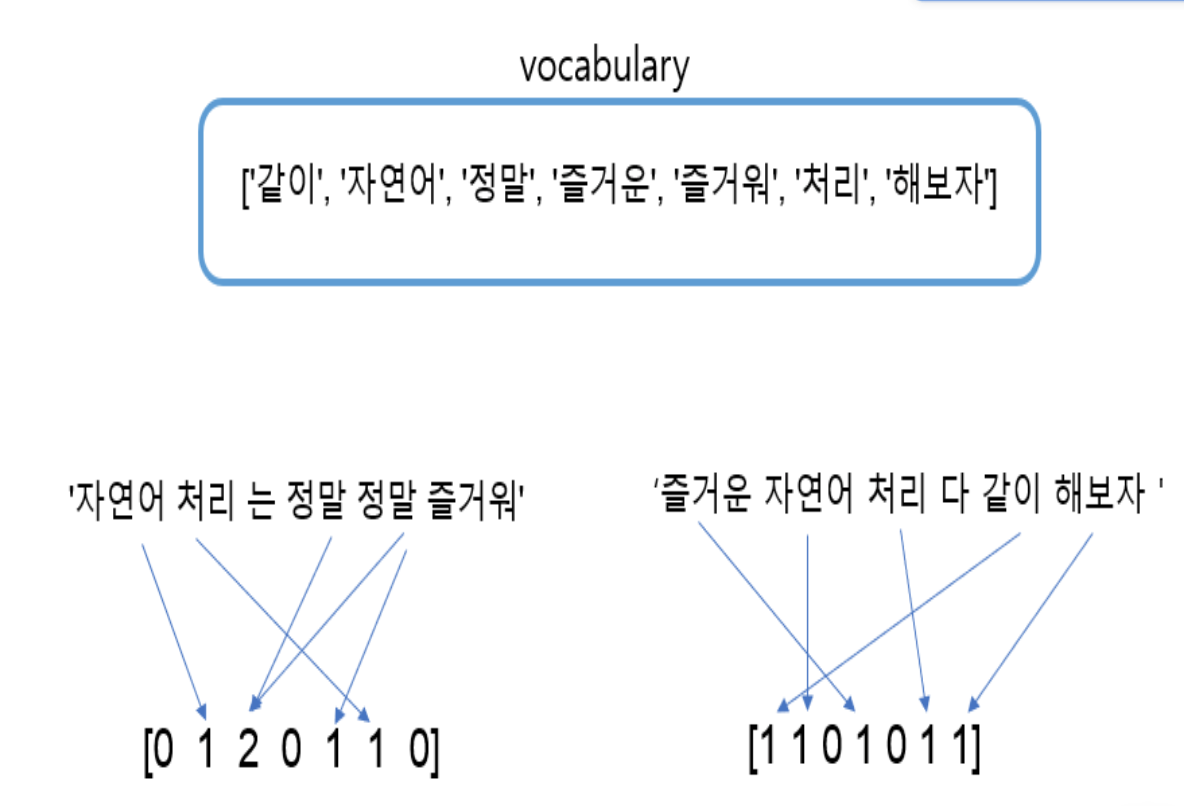

벡터화 결과 문장이 vocabulary의 인덱스를 기준으로 카운트가 정수로 표시된 것을 알 수 있으나 사이킷런의 카운트벡터라이저는 한글자는 자동제거

모델에서 같은 의미의 토큰을 다르게 학습할 수 있다는 것이 중요

## 3. TfIdf
단어가 몇번 등장했는지에 대한 정보
어떤 단어가 언급된 문서의 수가 적다면 그 단어는 문서를 분류하는데에 있어서 중요한 단어

즉 등장횟수와 문서분별력을 고려하여 단어들을 점수화하여 벡터화한 것

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=0)
tfidf_vectorizer = tfidf.fit_transform(tokens) 

#tf-idf dictionary    
tfidf_dict = tfidf.get_feature_names()
print(tfidf_dict)
print(tfidf_vectorizer.toarray())

# count vectorization과 동일하지만 가중치가 다름

## 4. padding

문장의 길이를 맞춰주기 위해 부족한 길이만큼 0을 채워놓는 것이 패딩

## 5. 대회 적용


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def text2sequence(train_text, max_len=100):
    
    tokenizer = Tokenizer() #keras의 vectorizing 함수 호출
    tokenizer.fit_on_texts(train_text) #train 문장에 fit
    train_X_seq = tokenizer.texts_to_sequences(train_text) #각 토큰들에 정수 부여
    vocab_size = len(tokenizer.word_index) + 1 #모델에 알려줄 vocabulary의 크기 계산
    print('vocab_size : ', vocab_size)
    X_train = pad_sequences(train_X_seq, maxlen = max_len) #설정한 문장의 최대 길이만큼 padding
    
    return X_train, vocab_size, tokenizer

train_X, vocab_size, vectorizer = text2sequence(train['text'], max_len = 100)